## ab_test naive_bayes & logistic_regression
by: Abdulalim Mohamed Abdulfatah 

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [108]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import seaborn as sns

`1.` Now, read in the `ab_data.csv` data. Store it in `df`. 

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#Read in the dataset and take a look at the top few rows here
df=pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# number of rows in the dataset
df.shape[0]

294478

c. The number of unique users in the dataset.

In [3]:
#unique users in the dataset
df["user_id"].nunique()

290584

d. The proportion of users converted.

In [4]:
#The proportion of users converted
df[df["converted"]==1].shape[0]/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [5]:
#The number of times the new_page and treatment don't line up
df_1=df.query("group=='treatment' and landing_page!='new_page'")
df_2=df.query("group!='treatment' and landing_page=='new_page'")
len(df_1)+len(df_2)

3893

f. Do any of the rows have missing values?

In [7]:
#number of missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use 

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [6]:
#remove the mismatch rows
df1 = df.drop(df[(df.group =="treatment") & (df.landing_page != "new_page")].index)

df2 = df1.drop(df1[(df.group =="control") & (df1.landing_page != "old_page")].index)



<ipython-input-6-d61d3b19261e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df1.drop(df1[(df.group =="control") & (df1.landing_page != "old_page")].index)


In [7]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [8]:
#number of unique ids 
df2["user_id"].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [9]:
#user_id repeated in df2
df2[df2.duplicated(["user_id"],keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
#rows 1899 and 2893

In [10]:
#Remove one of duplicate user
df2.drop(labels=2893,inplace=True)



a. What is the probability of an individual converting regardless of the page they receive?

In [11]:
df2["converted"].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2.query("group=='control'")["converted"].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2.query("group=='treatment'")["converted"].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
df2.query("landing_page=='new_page'").count()[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

#NO

No, there is not sufficient evidence to say that the new treatment page leads to more conversions.
50% of users received the old page and 50% of users recieved the new page 
only 12% from control group converted to new page and only 11.8% from treatment group coverted to new page

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

##### H0:Pold-Pnew >= 0
H1:Pnew-Pold >0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new=df["converted"].mean()
p_new

0.11965919355605512

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old=df["converted"].mean()
p_old

0.11965919355605512

c. What is $n_{new}$?

In [20]:
#calculate the number of users landed and new_page
n_new = len(df2.query('landing_page == "new_page"'))

n_new

145310

d. What is $n_{old}$?

In [21]:
#calculate the number of users landed and new_page
n_old = len(df2.query('landing_page != "new_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# Simulate  𝑛𝑛𝑒𝑤  transactions with a convert rate of  𝑝𝑛𝑒𝑤  under the null. Store these  𝑛𝑛𝑒𝑤 
new_page_converted= np.random.binomial(1,p_new,n_new)
new_page_converted.mean()

0.11903516619640768

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
#  Simulate  𝑛𝑜𝑙𝑑  transactions with a convert rate of  𝑝𝑜𝑙𝑑  under the null. Store these  𝑛𝑜𝑙𝑑
old_page_converted= np.random.binomial(1,p_old,n_old)
old_page_converted.mean()

0.11940195767997026

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
#  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑
new_page_converted.mean()-old_page_converted.mean()

-0.00036679148356258406

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [25]:
# run simulation 10000
p_diffs=[]
for _ in range(10000):
    new_page_converted= np.random.binomial(1,p_new,n_new).mean()
    old_page_converted= np.random.binomial(1,p_old,n_old).mean()
    p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Text(0.5, 1.0, 'Simulated Difference of new_page & old_page converted')

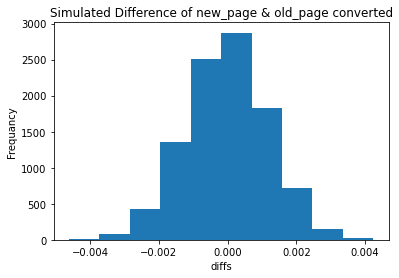

In [26]:
# convert to np array
p_diffs=np.array(p_diffs)
# Plot a histogram 
plt.hist(p_diffs);
plt.xlabel('diffs')
plt.ylabel('Frequancy')
plt.title('Simulated Difference of new_page & old_page converted')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
# calculate the obs diff 
df_control = df2.query("group=='control'")
df_treatment = df2.query("group=='treatment'")
obs_diff = df_treatment.converted.mean()-df_control.converted.mean()
obs_diff

-0.0015782389853555567

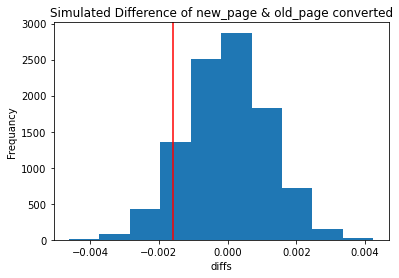

In [28]:
# # plot line for observed statistic
plt.hist(p_diffs);
plt.xlabel('diffs')
plt.ylabel('Frequancy')
plt.title('Simulated Difference of new_page & old_page converted')
plt.axvline(x=obs_diff, color="red")


In [29]:
#calculate the proportion of p_diffs greater than the observe difference
(p_diffs > obs_diff).mean()

0.9071

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

89.91% is the proportion of the p_diff that are greater than the actual difference observed in ab_data.csv. In scientific studies this value is also called p-value. This value means that we cannot reject the null hypothesis and that we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2.query("landing_page=='old_page' and converted==1").count()[0]
convert_new = df2.query("landing_page=='new_page' and converted==1").count()[0]
n_old = df2.query("landing_page=='old_page'").count()[0]
n_new =  df2.query("landing_page=='new_page'").count()[0]
(n_new,n_old)

(145310, 145274)

In [31]:
(convert_old,convert_new)

(17489, 17264)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],value=None, alternative='smaller', prop_var=False)

z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The z-score and the p_value mean that one doesn't reject the Null. The Null being the converted rate of the old_page is the same or greater than the converted rate of the new_page. The p_value is 0.91 and is higher than 0.05 significance level. That means we can not be confident with a 95% confidence level that the converted rate of the new_page is larger than the old_page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We need the logistic regression .**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [12]:
df2[['control','treatment']]= pd.get_dummies(df2['group'])
df2 = df2.drop('control',axis = 1)

df2.head()

,user_id,timestamp,group,landing_page,converted,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [13]:
df2 = df2.rename(columns={'treatment': 'ab_page'})
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [14]:
import statsmodels.api as sm
df2['intercept']=1
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 27 Jun 2022   Pseudo R-squ.:               8.077e-06
Time:                        18:29:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**P-value=0.19 it is greater than 0.05 so the coeffiction is not significant .

Alternative hypothesis from part II: the conversion rate of the old_page is less than the conversion rate of the new_page. This assumes a one-tailed test. In Part III, the alternative hypothesis can be formulated as follows: 
(1) The landing_page type influences (positively or negatively) the conversion rate or (2) the conversion rate of the old_page is different to the conversion rate of the new_page. This assumes a two-tailed test.

in both cases, the results do not support the alternative hypothesis sufficiently. 

The p-value is very different. In part II the p-value is 0.91. This might be because the tests of the regression model (not the A/B test) assumes an intercept and because of differences in one or two-tailed testing. 
**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is a good idea to consider other factors in order to identify other potential influences on the conversion rate. A disadvantage is that the model gets more complex..**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [15]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [16]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [17]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [18]:
df_new.ab_page.mean()

0.5000619442226688

In [19]:
df_new.groupby(["country"]).mean()

,converted,ab_page,intercept
country,,,
CA,0.115318,0.503552,1.0
UK,0.120594,0.498247,1.0
US,0.119547,0.500459,1.0


In [20]:
### Create the necessary dummy variables
df_new[['CA','UK','US']]= pd.get_dummies(df_new['country'])

In [21]:
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [22]:
### Fit Your Linear Model And Obtain the Results
df_new['intercept']=1
logit_mod = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','CA','UK']])
results=logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 27 Jun 2022   Pseudo R-squ.:               2.323e-05
Time:                        18:30:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [23]:
##mean conversion rate by country and landing_page - 
#checking for possible interactions (whether the influence of landing_page
#is different for the countries)
df_new.groupby(['country','ab_page'],as_index=False).mean()

,country,ab_page,converted,intercept,CA,UK,US
0,CA,0,0.118783,1.0,1,0,0
1,CA,1,0.111902,1.0,1,0,0
2,UK,0,0.120022,1.0,0,1,0
3,UK,1,0.121171,1.0,0,1,0
4,US,0,0.120630,1.0,0,0,1
5,US,1,0.118466,1.0,0,0,1


###### By looking at an interaction, I will explore whether the influence of the landing_page might work in the CA but not in the other countries, or UK but not in other countries.

In [24]:

df_new['interaction_CA_ab_page']= df_new.CA * df_new.ab_page
df_new['interaction_UK_ab_page']= df_new.UK * df_new.ab_page
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US,interaction_CA_ab_page,interaction_UK_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [25]:
# now we don't need US column so drop it 
df_new.drop('US',axis = 1, inplace = True )
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,interaction_CA_ab_page,interaction_UK_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


In [26]:
intercept=1
logit_mod = sm.Logit(df_new['converted'],df_new[['intercept','CA','interaction_CA_ab_page','UK','interaction_UK_ab_page']])
results= logit_mod.fit()
results.summary()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Mon, 27 Jun 2022   Pseudo R-squ.:               2.417e-05
Time:                        18:30:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2729
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA                        -0.0073      0.037     -0.196      0.844      -0.080       0.065
interaction_CA_ab_page    -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK                         0.0045      0.018      0.257      0.797      -0.030       0.039
interaction_UK_ab_page     0.0108      0.023      0.475      0.635      -0.034       0.056
==========================================================================================
"""

#### The p-value for CA country is greater than 0.05 and P-value for UK is greater than 0.05 so the country does not have influence on the converted rate 

##### Naive Bayes

In [92]:
countries_df = pd.read_csv('./countries.csv')
df = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [93]:
df=df.reset_index()
df.head()

,user_id,country,timestamp,group,landing_page,converted,ab_page,intercept
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [94]:
df=df.drop(['user_id','timestamp'],axis=1)
df.head()

,country,group,landing_page,converted,ab_page,intercept
0,UK,control,old_page,0,0,1
1,US,treatment,new_page,0,1,1
2,UK,treatment,new_page,1,1,1
3,UK,control,old_page,0,0,1
4,UK,treatment,new_page,0,1,1


In [98]:
df.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [99]:
df_new.group.unique()

array(['control', 'treatment'], dtype=object)

In [100]:
df_new.landing_page.unique()

array(['old_page', 'new_page'], dtype=object)

In [101]:
# encoding "country" Column
df['country'].replace({'UK':0,'US':1,'CA':2},inplace=True)
# encoding "group" Column
df['group'].replace({'control':0,'treatment':1},inplace=True)
# encoding "landing_page" Column
df['landing_page'].replace({'old_page':0,'new_page':1},inplace=True)
df.head()

,country,group,landing_page,converted,ab_page,intercept
0,0,0,0,0,0,1
1,1,1,1,0,1,1
2,0,1,1,1,1,1
3,0,0,0,0,0,1
4,0,1,1,0,1,1


In [102]:
X = df.drop(['ab_page'], axis=1)# features 
Y = df['ab_page'] # target 
print(X)
print(Y)

        country  group  landing_page  converted  intercept
0             0      0             0          0          1
1             1      1             1          0          1
2             0      1             1          1          1
3             0      0             0          0          1
4             0      1             1          0          1
...         ...    ...           ...        ...        ...
290579        1      0             0          0          1
290580        0      0             0          0          1
290581        0      0             0          0          1
290582        2      1             1          0          1
290583        0      0             0          0          1

[290584 rows x 5 columns]
0         0
1         1
2         1
3         0
4         1
         ..
290579    0
290580    0
290581    0
290582    1
290583    0
Name: ab_page, Length: 290584, dtype: uint8


In [103]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)


model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

In [106]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_pred, y_test)
print(cm)

[[28922     0]
 [    0 29195]]


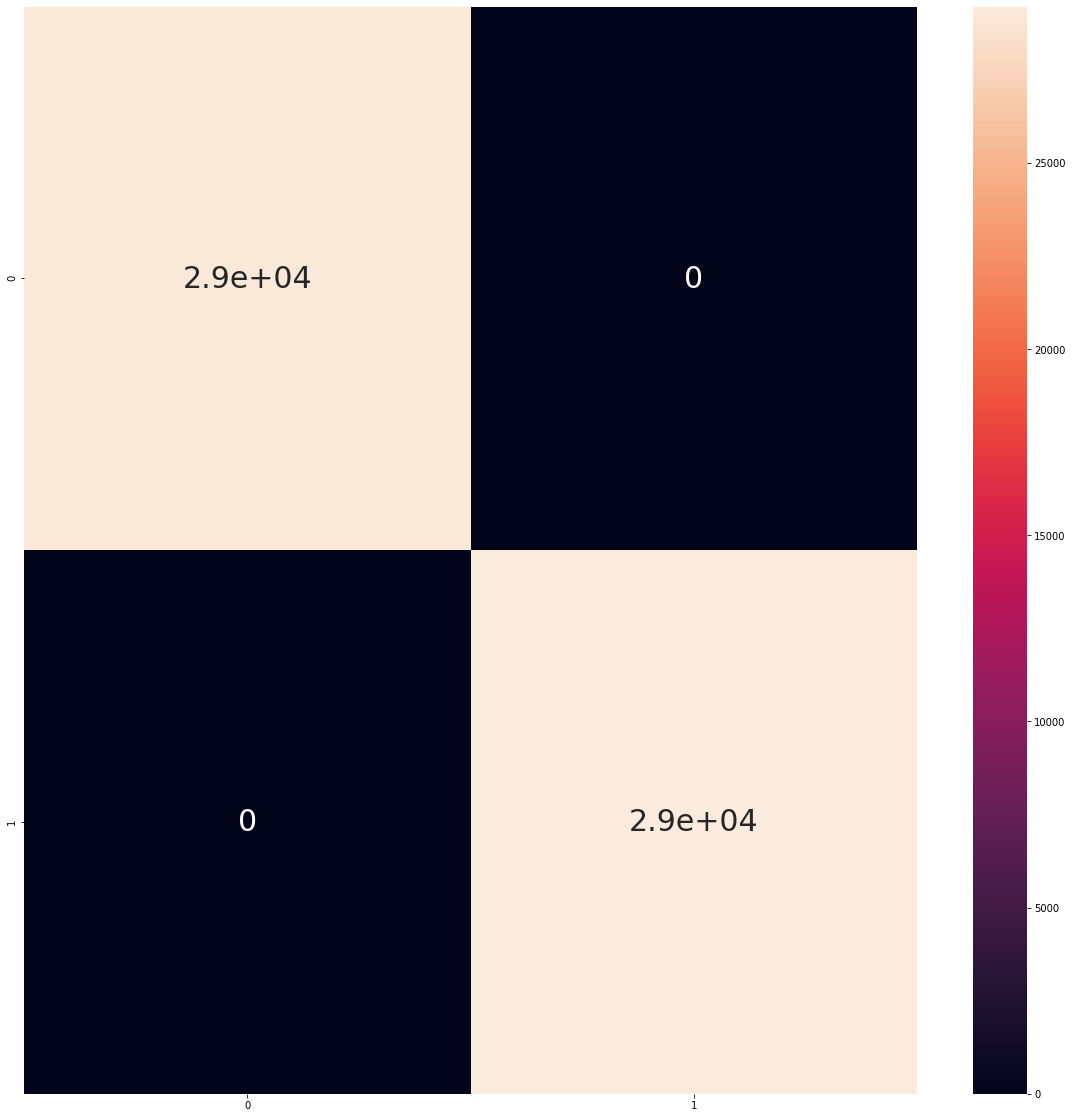

In [110]:
plt.rcParams['figure.figsize'] = (20, 20)

sns.heatmap(cm, annot = True, annot_kws = {'size':30})

sns.set_style({'xtick.bottom': True})

In [111]:
# Creating a function to report confusion metricsdef confusion_metrics (conf_matrix):# save confusion matrix and slice into four pieces   
TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]   
print('True Positives:', TP)
print('True Negatives:', TN)
print('False Positives:', FP)
print('False Negatives:', FN)

# calculate accuracy
conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))

# calculate mis-classification
conf_misclassification = 1- conf_accuracy

# calculate the sensitivity
conf_sensitivity = (TP / float(TP + FN))    
# calculate the specificity
conf_specificity = (TN / float(TN + FP))

# calculate precision
conf_precision = (TN / float(TN + FP))    # calculate f_1 score
conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))  
print('-'*50)
print(f'Accuracy: {round(conf_accuracy,2)}') 
print(f'Mis-Classification: {round(conf_misclassification,2)}') 
print(f'Sensitivity: {round(conf_sensitivity,2)}') 
print(f'Specificity: {round(conf_specificity,2)}') 
print(f'Precision: {round(conf_precision,2)}')
print(f'f_1 Score: {round(conf_f1,2)}')

True Positives: 29195
True Negatives: 28922
False Positives: 0
False Negatives: 0
--------------------------------------------------
Accuracy: 1.0
Mis-Classification: 0.0
Sensitivity: 1.0
Specificity: 1.0
Precision: 1.0
f_1 Score: 1.0


<a id='conclusions'></a>
## Conclusions

There is no evidence that the new page better than old page in conversion rate based on the probability figures , A-B test and regression. And there is no evidence that countries ( US,CA,UK) influence the converssion rate.